In [149]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sb
import scipy
from scipy import stats
import pandas_to_pybeh as pb

In [148]:
### Now using terciles generated in the fifth cell
# BAI_high = 15
# BAI_low = 8
# BDI_high = 16
# BDI_low = 10

sel_sub = pd.DataFrame([])
master = pd.read_excel(r'./220302_all_neuropsych.xlsx',engine="openpyxl") #read master spreadsheet of all RAM subjects demo/neuropsych data


In [156]:
# demographics['subject']=np.zeros(len(demographics))*np.nan # set a new columns with Nans
sub_mat=list(np.zeros(len(master))*np.nan )
df = get_data_index('r1')
# df_select = pd.DataFrame([])
for sub in df['subject'].unique():
    num = int(sub[2:5])
    for i in master.index:
        sel = master.iloc[i]['Subject Number']
        if sel == num:
            sub_mat[i]=sub
# df_select[0:50]
master['subject']=sub_mat
master

,Subject Number,Study site,Gender,Years of Education,Age of seizure onset,Age at Implant (calculated),Phase II Implant Date,Phase III Implant Date,Traumatic Brain Injury (TBI) Notes,Date of Pre-operative Report,...,GAI,VCI,PRI,WMI,Pre-operative Report,Prior Neurosurgical Procedures (can select more than one),Prior Surgery: Resection Detail,Prior Surgery: Callosotomy Detail,Prior Surgery: Laser Ablation Detail,subject
0,1,University of Pennsylvania,Female,13.0,20.0,48.105026,2014-10-08,NaT,NaN,NaT,...,76.0,81,75,NaN,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,R1001P
1,2,University of Pennsylvania,Female,16.0,34.0,49.383743,2014-11-12,NaT,NaN,NaT,...,84.0,89,84,NaN,R1002P_neuropsych.pdf,NaN,NaN,NaN,NaN,R1002P
2,3,University of Pennsylvania,Female,13.0,37.0,39.390382,2014-11-13,NaT,motor vehicle accident due to loss of consciou...,NaT,...,NaN,107,100,NaN,R1003P_neuropsych.pdf,NaN,NaN,NaN,NaN,R1003P
3,4,Dartmouth University,Female,12.0,6.0,51.918931,2014-11-06,NaT,"In early 90s, motor vehicle accident resulting...",NaT,...,NaN,78,82,NaN,R1004D Neuropsych.pdf,NaN,NaN,NaN,NaN,R1004D
4,5,University of Pennsylvania,Female,NaN,NaN,20.304432,2015-01-14,NaT,NaN,NaT,...,89.0,98,82,NaN,R1005P_neuropsych.pdf,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,597,Jefferson Hospital,Male,NaN,NaN,NaN,2021-12-10,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,598,Emory University,Female,12.0,16.0,39.568346,2021-12-15,NaT,NaN,2019-02-19,...,96.0,103,88,NaN,R1598E-Neuropsychologic Report_redacted.pdf,Laser ablation (i.e. Visualase),NaN,NaN,right anterior temporal hippocampus laser abla...,R1598E
598,599,UT Southwestern,Male,NaN,8.0,20.728808,2022-02-04,NaT,NaN,2019-06-03,...,101.0,98,104,NaN,NP report - 1599.pdf,Laser ablation (i.e. Visualase),NaN,NaN,Litt 1 2/2018 Left SMA Litt 2 11/2018 Mesial ...,NaN
599,600,UT Southwestern,Male,15.0,6.0,27.896534,2018-03-27,2022-02-07,NaN,2017-06-27,...,NaN,NaN,14,NaN,Neuropsych_R1600T.docx,"VNS implant,RNS implant (Neuropace)",NaN,NaN,NaN,NaN


In [157]:
subs = master.dropna(subset=['BAI', 'BDI', 'subject'])
len(subs)

196

In [90]:
trial_df = pd.DataFrame([])
list_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in master['subject']:
    try:
        for exp in experiments:
            localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

            for loc in localizations:
                montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

                for mont in montages: # iterate over montages            
                    data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                    sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                    for sess in sessions: 
                        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                        evs = reader.load('task_events')
                        word_evs = evs[evs['type']=='REC_WORD']

                        #exclude practice lists 
                        lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                        corr_recs = len(word_evs[word_evs['intrusion']==0])
                        ELIs = len(word_evs[word_evs['intrusion']==-1])
                        PLIs = len(word_evs[word_evs['intrusion']>0])
                        total_ints = ELIs + PLIs
                        total_trials = corr_recs + total_ints
                        row = master[master['subject']==sub] #get row of BAI/BDI scores for subject
                        BAI = row['BAI'].item()
                        BDI = row['BDI'].item()

                        trials = [] #make list of event numbers of analysis
                        for list_num in word_evs['list'][word_evs['list']>0].unique():
                            list_events=word_evs[word_evs['list']==list_num]
                            if len(list_events)>0: 
                                for i in range(0,len(list_events)):
                                    trials.append(list_events.index[i])
                            PLI = len(list_events[list_events['intrusion']>0])
                            ELI = len(list_events[list_events['intrusion']==-1])
                            correc = len(list_events[list_events['intrusion']==0])
                            
                            list_df = list_df.append({ #create dataframe of events for analysis grouped by list ##should I filter out lists with no events?
                                'subject':sub,
                                'session': sess,
                                'experiment': exp,
                                'list': list_num,
                                'number of correct recalls': correc,
                                'number of extra-list intrusions': ELI,
                                'number of prior-list intrusions': PLI,
                                'total number of intrusions': ELI+PLI,
                                'BAI':BAI,
                                'BDI':BDI
                                },ignore_index=True) 
                        trial_df = trial_df.append({ #create dataframe of events for analysis grouped by session
                            'subject':sub,
                            'session': sess,
                            'montage': mont,
                            'localization': loc,
                            'experiment': exp,
                            'number of lists': lists,
                            'number of correct recalls': corr_recs,
                            'number of extra-list intrusions': ELIs,
                            'number of prior-list intrusions': PLIs,
                            'total number of intrusions': total_ints,
                            'total number of trials left': total_trials,
                            'trials for analysis': trials,
                            'BAI':BAI,
                            'BDI':BDI
                            },ignore_index=True) 
    except:
        print('Failed for subject:', sub)
list_df[:100]

,BAI,BDI,experiment,list,number of correct recalls,number of extra-list intrusions,number of prior-list intrusions,session,subject,total number of intrusions
0,8.0,2.0,FR1,2.0,2.0,0.0,2.0,0.0,R1001P,2.0
1,8.0,2.0,FR1,3.0,4.0,3.0,1.0,0.0,R1001P,4.0
2,8.0,2.0,FR1,4.0,2.0,3.0,1.0,0.0,R1001P,4.0
3,8.0,2.0,FR1,7.0,2.0,2.0,0.0,0.0,R1001P,2.0
4,8.0,2.0,FR1,8.0,3.0,1.0,1.0,0.0,R1001P,2.0
...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,FR1,1.0,5.0,3.0,0.0,0.0,R1003P,3.0
96,NaN,NaN,FR1,2.0,4.0,2.0,0.0,0.0,R1003P,2.0
97,NaN,NaN,FR1,3.0,5.0,0.0,0.0,0.0,R1003P,0.0
98,NaN,NaN,FR1,4.0,7.0,1.0,0.0,0.0,R1003P,1.0


In [165]:
## Find terciles for high/low BAI and BDI subsets
BAI = []
BDI = []
for sub in trial_df['subject'].unique():
    sub_row = trial_df[trial_df['subject']==sub].iloc[0]
    if pd.isnull(sub_row['BAI'])==False:
        BAI.append(sub_row['BAI'])
    if pd.isnull(sub_row['BDI'])==False:
        BDI.append(sub_row['BDI'])
    
# BAI_df = trial_df[trial_df['subject'].unique()].dropna('BAI')
# BDI_df = trial_df[trial_df['subject'].unique()].dropna('BDI')
BAI_low = np.quantile(BAI, float(1/3))
BAI_high = np.quantile(BAI, float(2/3))
BDI_low = np.quantile(BAI, float(1/3))
BAI_high = np.quantile(BAI, float(2/3))

BDI_low


5.0

In [161]:
subs = trial_df.dropna(subset=['BDI'])
len(subs['subject'].unique())

151

280

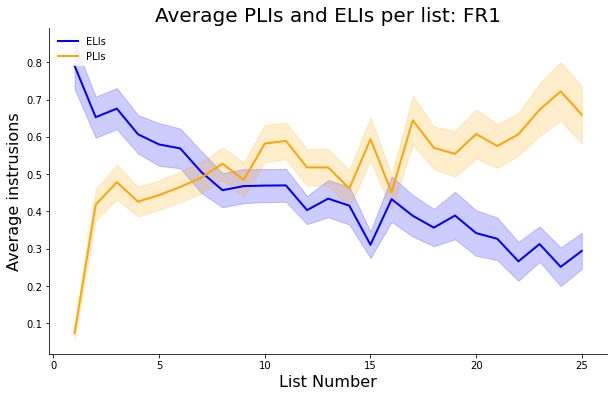

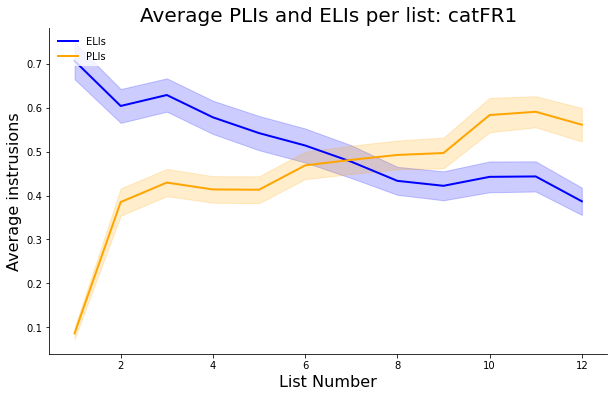

In [152]:
#BEGINNING OF LIST-LEVEL ANALYSES
experiments = ['FR1', 'catFR1']
colors = ['blue', 'orange']
correc = []
ELI = []
PLI = []

#Create dataframe of recall type averaged over list number
exp_sum_df = pd.DataFrame([])
sub_avg_df = pd.DataFrame([])
for exp in experiments:
    exp_list_df = list_df[list_df['experiment']==exp]
    if exp=='FR1':
        nlist = 25
    elif exp=='catFR1': ##there are 30 subjects who ran CatFR1 with 25 lists rather than 12. Need to figure out how to interpret the second half of those sessions
        nlist = 12
    for sub in exp_list_df['subject'].unique():
        sub_exp_df = exp_list_df[exp_list_df['subject']==sub]
        for i in range(1,nlist+1):
            sub_list_sel = sub_exp_df[sub_exp_df['list']==i]
            correc = np.mean(sub_list_sel['number of correct recalls'])
            ELI = np.mean(sub_list_sel['number of extra-list intrusions'])
            PLI = np.mean(sub_list_sel['number of prior-list intrusions'])
            sub_avg_df = sub_avg_df.append({
                'subject':sub,
                'list':i,
                'experiment':exp,
                'number of correct recalls':correc,
                'number of prior-list intrusions':PLI,
                'number of extra-list intrusions':ELI,
                'BAI':sub_exp_df.iloc[0]['BAI'],
                'BDI':sub_exp_df.iloc[0]['BDI']
             }, ignore_index=True)
    for i in range(1,nlist+1):
        list_sel = sub_avg_df[sub_avg_df['list']==i]
        correc = np.mean(list_sel['number of correct recalls'])
        ELI = np.mean(list_sel['number of extra-list intrusions'])
        ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        PLI = np.mean(list_sel['number of prior-list intrusions'])
        PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        exp_sum_df = exp_sum_df.append({
            'experiment':exp,
            'list':i,
            'average correct recalls':correc,
            'average ELIs':ELI,
            'ELI_sem':ELI_sem,
            'average PLIs':PLI,
            'PLI_sem':PLI_sem
        }, ignore_index=True)
    
    sel_sum_df = exp_sum_df.query("experiment=='"+exp+"'")
    #sel_sum_df = exp_sum_df[exp_sum_df['experiment']==exp]
    lst = list(sel_sum_df['list'])
    meanELIs = sel_sum_df['average ELIs']
    meanPLIs = sel_sum_df['average PLIs']
    semELIs = sel_sum_df['ELI_sem']
    semPLIs = sel_sum_df['PLI_sem']
    
    plt.figure(figsize=(10,6))
    plt.plot(lst,meanELIs,linewidth=2,color=colors[0])
    plt.fill_between(lst,meanELIs-semELIs,meanELIs+semELIs,color=colors[0],alpha=0.2)
    plt.plot(lst,meanPLIs,linewidth=2,color=colors[1])
    plt.fill_between(lst,meanPLIs-semPLIs,meanPLIs+semPLIs,color=colors[1],alpha=0.2)
    plt.title('Average PLIs and ELIs per list: '+exp, fontsize=20)
    plt.xlabel('List Number',fontsize=16)
    plt.ylabel('Average instrusions',fontsize=16)
    plt.legend(('ELIs','PLIs'),loc='upper left',edgecolor="None")
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    #plt.savefig('PLIvELI '+ exp+ '.pdf')

len(list_df[list_df['experiment']=='FR1']['subject'].unique())
# long_cat = list_df[np.logical_and(list_df['experiment']==exp, list_df['list']>12)]
# long_cat['subject'].unique()

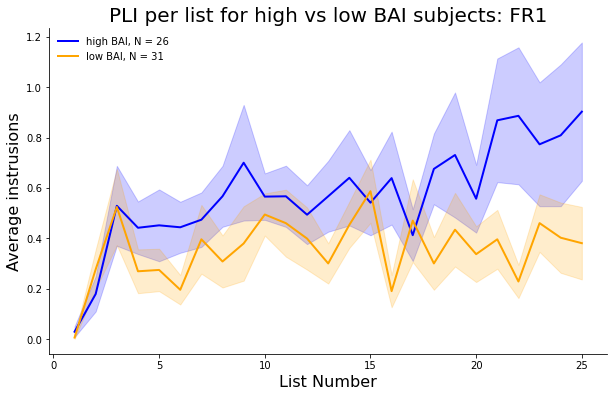

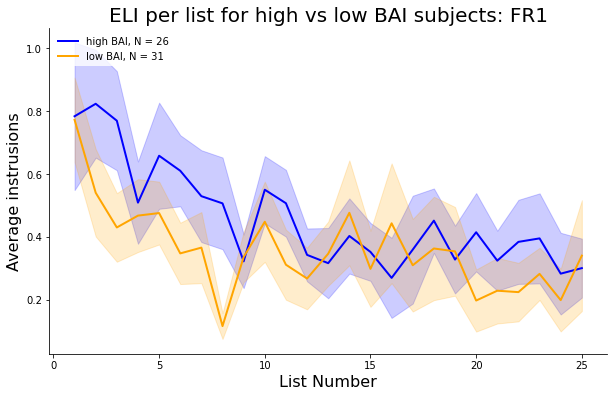

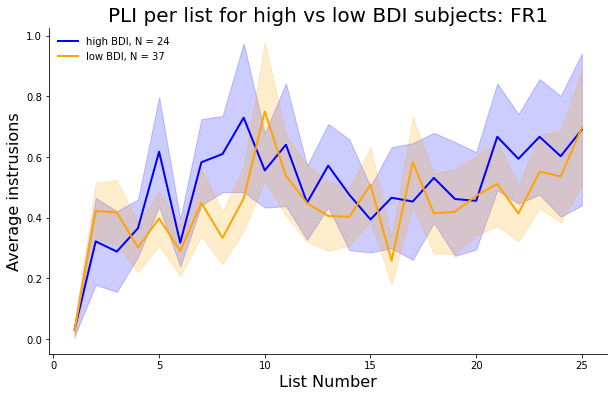

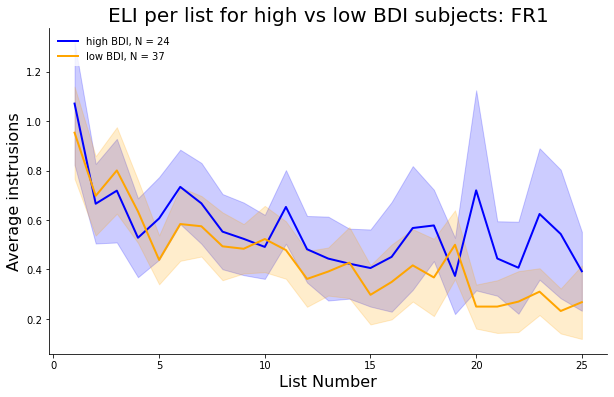

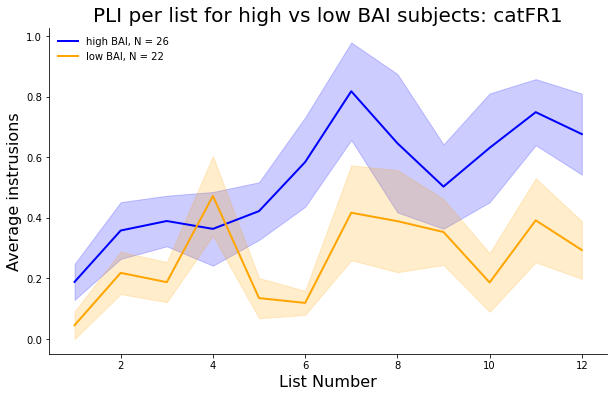

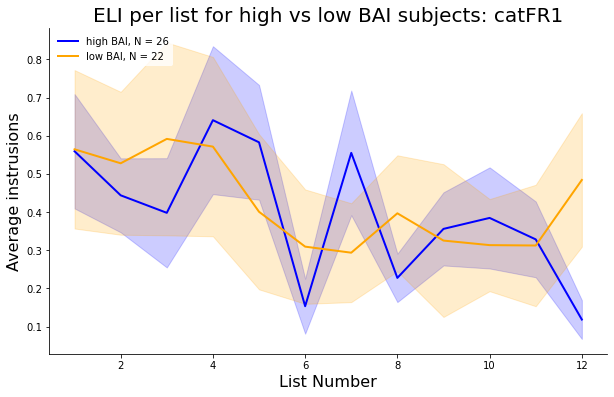

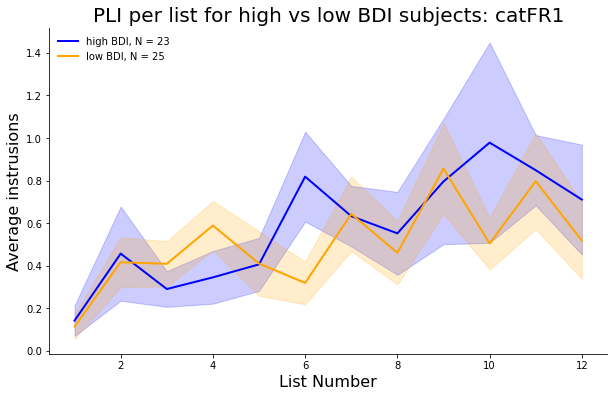

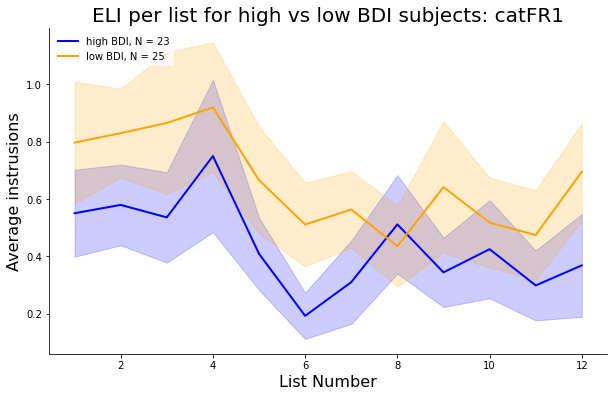

In [128]:
dependents = ['PLI', 'ELI']
metrics = ['BAI','BDI']
levels = ['high','low']

#Compare high and low BAI/BDI subjects for each type of intrusions by list in both experiments using sub avg dataframe from last cell^
for exp in experiments:
    for met in metrics:
        for dep in dependents:
            split_sum_df = pd.DataFrame([])
            exp_list_df = sub_avg_df[sub_avg_df['experiment']==exp]  
            if exp=='FR1':
                nlist = 25
            elif exp=='catFR1':
                nlist = 12
            if met=='BAI':
                exp_list_df_high = exp_list_df[exp_list_df['BAI']>BAI_high]
                exp_list_df_low = exp_list_df[exp_list_df['BAI']<BAI_low]
            elif met=='BDI':
                exp_list_df_high = exp_list_df[exp_list_df['BDI']>BDI_high]
                exp_list_df_low = exp_list_df[exp_list_df['BDI']<BDI_low]
            for lev in levels:
                if lev =='high':
                    exp_list_df_filt = exp_list_df_high
                elif lev=='low':
                    exp_list_df_filt = exp_list_df_low
                for i in range(1,nlist+1):
                    list_sel = exp_list_df_filt[exp_list_df_filt['list']==i]
                    correc = np.mean(list_sel['number of correct recalls'])
                    correc_sem = scipy.stats.sem(list_sel['number of correct recalls'],axis=0,ddof=1,nan_policy='omit')
                    ELI = np.mean(list_sel['number of extra-list intrusions'])
                    ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    PLI = np.mean(list_sel['number of prior-list intrusions'])
                    PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    split_sum_df = split_sum_df.append({
                        'experiment':list_sel.iloc[0]['experiment'],
                        'list':i,
                        'average correct recalls':correc,
                        'correct recall_sem':correc,
                        'average ELIs':ELI,
                        'ELI_sem':ELI_sem,
                        'average PLIs':PLI,
                        'PLI_sem':PLI_sem,
                        'metric':met,
                        'level':lev
                    }, ignore_index=True)
            lst = list(split_sum_df['list'].unique())
            high_ints = list(split_sum_df[split_sum_df['level']=='high']['average '+dep+'s'])
            low_ints = list(split_sum_df[split_sum_df['level']=='low']['average '+dep+'s'])
            sem_high = split_sum_df[split_sum_df['level']=='high'][dep+'_sem']
            sem_low = split_sum_df[split_sum_df['level']=='low'][dep+'_sem']
            N_highsubs = len(exp_list_df_high['subject'].unique())
            N_lowsubs = len(exp_list_df_low['subject'].unique())

            plt.figure(figsize=(10,6))
            plt.plot(lst,high_ints,linewidth=2,color=colors[0])
            plt.fill_between(lst,high_ints-sem_high,high_ints+sem_high,color=colors[0],alpha=0.2)
            plt.plot(lst,low_ints,linewidth=2,color=colors[1])
            plt.fill_between(lst,low_ints-sem_low,low_ints+sem_low,color=colors[1],alpha=0.2)
            plt.title(dep+' per list for high vs low '+met+' subjects: '+exp, fontsize=20)
            plt.xlabel('List Number',fontsize=16)
            plt.ylabel('Average instrusions',fontsize=16)
            plt.legend(('high '+met+', N = '+str(N_highsubs),'low '+met+', N = '+str(N_lowsubs)),loc='upper left',edgecolor="None")
            plt.gca().spines['right'].set_color('none')
            plt.gca().spines['top'].set_color('none')
            #plt.savefig(dep+' per list for high vs low '+met+' subjects: '+exp+'.pdf')

In [129]:
#BEGINNING OF SESSION LEVEL ANALYSES
#trial_df = trial_df.dropna(subset=['BAI','BDI'])
df_filter = pd.DataFrame([])
#Create dataframe of important session stats. Scale PLIs, ELIs, and correct recalls. Add BAI/BDI scores.
for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        PLI_scaled = float(pli/lists) ##Need to confirm scaling method with Mike
        ELI_scaled = float(eli/lists)
        correc_scaled = float(correc/lists)
        BAI = trial_df.iloc[i]['BAI']
        BDI = trial_df.iloc[i]['BDI']
#         PLI_scaled = float(pli/allrec) 
#         ELI_scaled = float(eli/allrec)
#         correc_scaled = float(correc/allrec)
        if allrec > 0 and lists > 0: #remove sessions with no valid recalls
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':BAI,
                'BDI':BDI
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp, "for no valid recalls or no lists")
    except:
        print('Analysis failed for row =', i, sub, exp)
df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


removed row = 12 R1015J FR1 for no valid recalls or no lists
removed row = 158 R1100D FR1 for no valid recalls or no lists
removed row = 159 R1100D FR1 for no valid recalls or no lists


/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


removed row = 1004 R1491T catFR1 for no valid recalls or no lists


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,8.0,2.0,0.954545,21.0,1.136364,25.0,108.0,62.0,2.818182,FR1,22.0,R1001P,46.0,2.090909
1,8.0,2.0,0.826087,19.0,0.739130,17.0,99.0,63.0,2.739130,FR1,23.0,R1001P,36.0,1.565217
2,9.0,0.0,0.120000,3.0,0.320000,8.0,128.0,117.0,4.680000,FR1,25.0,R1002P,11.0,0.440000
3,9.0,0.0,0.080000,2.0,0.120000,3.0,125.0,120.0,4.800000,FR1,25.0,R1002P,5.0,0.200000
4,NaN,NaN,1.363636,30.0,1.181818,26.0,142.0,86.0,3.909091,FR1,22.0,R1003P,56.0,2.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,NaN,NaN,0.666667,6.0,0.111111,1.0,31.0,24.0,2.666667,FR1,9.0,R1565T,7.0,0.777778
1099,NaN,NaN,0.640000,16.0,0.720000,18.0,102.0,68.0,2.720000,FR1,25.0,R1569T,34.0,1.360000
1100,NaN,NaN,0.458333,11.0,0.750000,18.0,106.0,77.0,3.208333,FR1,24.0,R1571T,29.0,1.208333
1101,6.0,10.0,0.800000,4.0,0.800000,4.0,23.0,15.0,3.000000,FR1,5.0,R1572T,8.0,1.600000


total PLI = 9018.0
total ELI = 8669.0
mean diff = -0.015012512003647914
median diff = 0.0


Text(-0.015012512003647914, 15, '  Mean: -0.0')

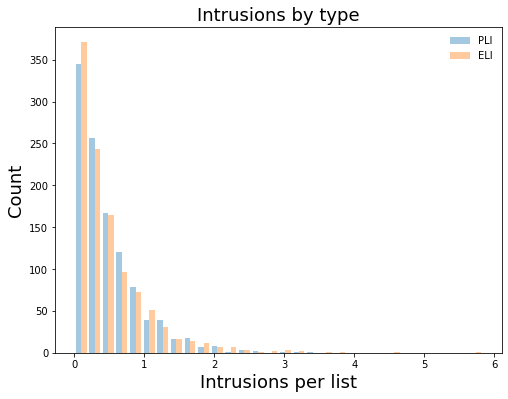

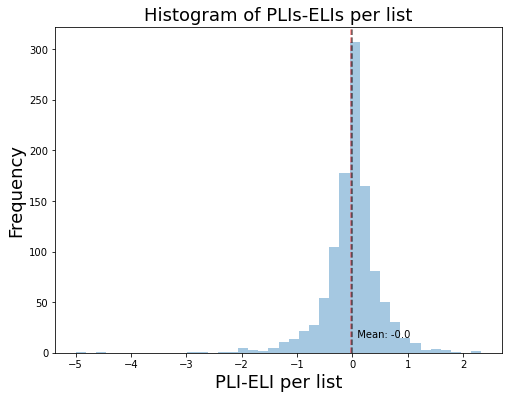

In [131]:
#get intrusion per session counts to generate a histogram
df_int = pd.DataFrame([])
for i in df_filter.index:
    sub = df_filter.iloc[i]['subject']
    exp = df_filter.iloc[i]['experiment']
    PLI = df_filter.iloc[i]['PLIs']
    ELI = df_filter.iloc[i]['ELIs']
    lists = df_filter.iloc[i]['lists']
    sPLI = float(PLI/lists)
    sELI = float(ELI/lists)
    diff = sPLI-sELI
    df_int = df_int.append({
        'subject':sub,
        'experiment':exp,
        'ELIs':ELI,
        'PLIs':PLI,
        'lists':lists,
        'ELIs per list':sELI,
        'PLIs per list':sPLI,
        'PLI minus ELI per list':diff,
    }, ignore_index=True)

total_PLI = np.sum(df_int['PLIs'])
total_ELI = np.sum(df_int['ELIs'])
PLI_list = list(df_int['PLIs per list'])
ELI_list = list(df_int['ELIs per list'])
diff_list = list(df_int['PLI minus ELI per list'])

plt.figure(figsize=(8,6))
int_hist = plt.hist((PLI_list, ELI_list), 30,alpha=0.4)
plt.xlabel('Intrusions per list',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Intrusions by type',fontsize=18)
plt.legend(('PLI','ELI'),loc='upper right',edgecolor="None")
#plt.savefig('Histogram of intrusion type frequency.pdf')

print('total PLI =', total_PLI)
print('total ELI =', total_ELI)

plt.figure(figsize=(8,6))
diff_hist = plt.hist(diff_list, 40,alpha=0.4)
plt.xlabel('PLI-ELI per list',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of PLIs-ELIs per list',fontsize=18)

mean = np.mean(diff_list)
median = np.median(diff_list)

plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
print('mean diff =', mean)
print('median diff =', median)

plt.text(mean,15,'  Mean: %.1f' %(mean/30))
#plt.savefig('Histogram of PLIs-ELIs per session.pdf')

In [36]:
np.mean(diff_list)

-0.015012512003647914

In [132]:
#average across sessions from the same subject
avg_df = pd.DataFrame([])
df_filter_drop = df_filter.dropna(subset=['BAI','BDI'])
sub_df = df_filter_drop['subject'].unique()

for exp in experiments:
    exp_df_filter = df_filter_drop[df_filter_drop['experiment']==exp]
    exp_sub_df = exp_df_filter['subject'].unique()
    for sub in exp_sub_df:
        trials = exp_df_filter[exp_df_filter['subject']==sub]
        df_mean = trials.mean(axis=0)
        avg_eli = df_mean['ELI scaled']
        avg_pli = df_mean['PLI scaled']
        avg_int = df_mean['total scaled']
        avg_cor = df_mean['correct recalls scaled']
        avg_df = avg_df.append({
            'subject':sub,
            'experiment':exp,
            'average ELIs':avg_eli,
            'average PLIs':avg_pli,
            'average ints': avg_int,
            'average correct recalls':avg_cor,
            'BAI':df_mean['BAI'],
            'BDI':df_mean['BDI']
            }, ignore_index = True)

avg_df
#len(avg_df[avg_df['experiment']=='catFR1']['subject'].unique())

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject
0,8.0,2.0,0.890316,0.937747,2.778656,1.828063,FR1,R1001P
1,9.0,0.0,0.100000,0.220000,4.740000,0.320000,FR1,R1002P
2,7.0,7.0,0.449231,0.535385,4.120000,0.984615,FR1,R1006P
3,2.0,1.0,0.130435,0.391304,2.456522,0.521739,FR1,R1010J
4,0.0,2.0,0.083333,0.625000,2.833333,0.708333,FR1,R1018P
...,...,...,...,...,...,...,...,...
160,5.0,6.0,0.200000,0.600000,3.200000,0.800000,catFR1,R1526J
161,18.0,16.0,0.277778,1.194444,9.638889,1.472222,catFR1,R1530J
162,12.0,21.0,1.166667,3.416667,5.083333,4.583333,catFR1,R1533J
163,24.0,17.0,0.253788,0.950758,4.001894,1.204545,catFR1,R1536J


In [133]:
mean=np.mean(avg_df[avg_df['experiment']=='FR1']['average ints'])
std=np.std(avg_df[avg_df['experiment']=='FR1']['average ints'], ddof=1)

print(avg_df[avg_df['experiment']=='FR1']['average ints'].std(ddof=1))
print(std)

0.8410832460933231
0.8410832460933231


In [134]:
FR_avg_df = avg_df.query("experiment == 'FR1'")
catFR_avg_df = avg_df.query("experiment == 'catFR1'")

FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]

FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()


FR_df_zscore.rename(columns = {'average ELIs':'zELI','average PLIs':'zPLI', 'average ints':'zints',
                              'average correct recalls':'zcorrect'}, inplace = True)

catFR_df_zscore.rename(columns = {'average ELIs':'zELI','average PLIs':'zPLI', 'average ints':'zints',
                              'average correct recalls':'zcorrect'}, inplace = True)

FR_avg_df['zELI']=FR_df_zscore['zELI']
FR_avg_df['zPLI']=FR_df_zscore['zPLI']
FR_avg_df['zints']=FR_df_zscore['zints']
FR_avg_df['zcorrect']=FR_df_zscore['zcorrect']
catFR_avg_df['zELI']=catFR_df_zscore['zELI']
catFR_avg_df['zPLI']=catFR_df_zscore['zPLI']
catFR_avg_df['zints']=catFR_df_zscore['zints']
catFR_avg_df['zcorrect']=catFR_df_zscore['zcorrect']
full_df=pd.concat((FR_avg_df,catFR_avg_df))

#any(np.isnan(full_df['BDI']))
full_df #Not sure what is up with these warnings

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrect
0,8.0,2.0,0.890316,0.937747,2.778656,1.828063,FR1,R1001P,0.657593,0.998357,0.913241,-0.442907
1,9.0,0.0,0.100000,0.220000,4.740000,0.320000,FR1,R1002P,-0.890955,-0.658435,-0.879760,1.320577
2,7.0,7.0,0.449231,0.535385,4.120000,0.984615,FR1,R1006P,-0.206671,0.069575,-0.089570,0.763123
3,2.0,1.0,0.130435,0.391304,2.456522,0.521739,FR1,R1010J,-0.831321,-0.263009,-0.639903,-0.732545
4,0.0,2.0,0.083333,0.625000,2.833333,0.708333,FR1,R1018P,-0.923612,0.276436,-0.418054,-0.393746
...,...,...,...,...,...,...,...,...,...,...,...,...
160,5.0,6.0,0.200000,0.600000,3.200000,0.800000,catFR1,R1526J,-0.514695,0.190308,-0.162231,-0.632525
161,18.0,16.0,0.277778,1.194444,9.638889,1.472222,catFR1,R1530J,-0.339756,1.356937,0.664803,3.010232
162,12.0,21.0,1.166667,3.416667,5.083333,4.583333,catFR1,R1533J,1.659548,5.718164,4.492395,0.432958
163,24.0,17.0,0.253788,0.950758,4.001894,1.204545,catFR1,R1536J,-0.393714,0.878688,0.335481,-0.178859


In [135]:
#Create dataframe that averages values for subjects that ran both experiments into one data point 
# not a good idea... we should leave then seperate.
full_df_comb = pd.DataFrame([])
for sub in full_df['subject'].unique():
    sub_df = full_df[full_df['subject']==sub]
    if len(sub_df) > 1:
        avg_sub_df = sub_df.mean(axis=0)
        exp = 'both'
    else:
        avg_sub_df = sub_df
        exp = str(sub_df['experiment'].values) ##All the dataframes in this cell keep outputting all info for a cell instead of values
    full_df_comb = full_df_comb.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':float(avg_sub_df['average ELIs']),
        'average PLIs':float(avg_sub_df['average PLIs']),
        'average ints':float(avg_sub_df['average ints']),
        'average correct recalls':float(avg_sub_df['average correct recalls']),
        'zELI':float(avg_sub_df['zELI']),
        'zPLI':float(avg_sub_df['zPLI']),
        'zints':float(avg_sub_df['zints']),
        'zcorrect':float(avg_sub_df['zcorrect']),
        'BAI':avg_sub_df['BAI'].item(),
        'BDI':avg_sub_df['BDI'].item()
        }, ignore_index = True)

full_df_comb
#any(np.isnan(full_df_comb['BDI']))

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zcorrect,zints
0,8.0,2.0,0.890316,0.937747,2.778656,1.828063,['FR1'],R1001P,0.657593,0.998357,-0.442907,0.913241
1,9.0,0.0,0.100000,0.220000,4.740000,0.320000,['FR1'],R1002P,-0.890955,-0.658435,1.320577,-0.879760
2,7.0,7.0,0.449231,0.535385,4.120000,0.984615,['FR1'],R1006P,-0.206671,0.069575,0.763123,-0.089570
3,2.0,1.0,0.130435,0.391304,2.456522,0.521739,['FR1'],R1010J,-0.831321,-0.263009,-0.732545,-0.639903
4,0.0,2.0,0.083333,0.625000,2.833333,0.708333,['FR1'],R1018P,-0.923612,0.276436,-0.393746,-0.418054
...,...,...,...,...,...,...,...,...,...,...,...,...
115,6.0,3.0,0.723485,0.560101,5.961869,1.283586,['catFR1'],R1525J,0.662736,0.112005,0.929983,0.432724
116,5.0,6.0,0.200000,0.600000,3.200000,0.800000,['catFR1'],R1526J,-0.514695,0.190308,-0.632525,-0.162231
117,18.0,16.0,0.277778,1.194444,9.638889,1.472222,['catFR1'],R1530J,-0.339756,1.356937,3.010232,0.664803
118,12.0,21.0,1.166667,3.416667,5.083333,4.583333,['catFR1'],R1533J,1.659548,5.718164,0.432958,4.492395


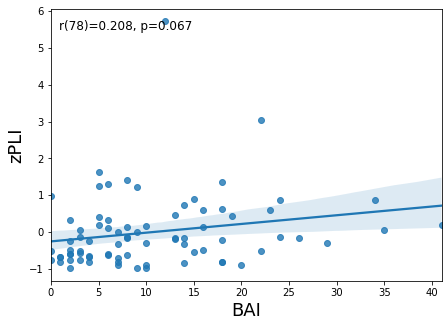

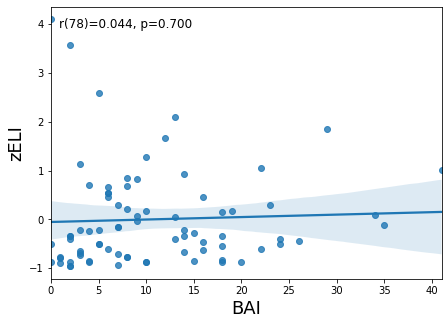

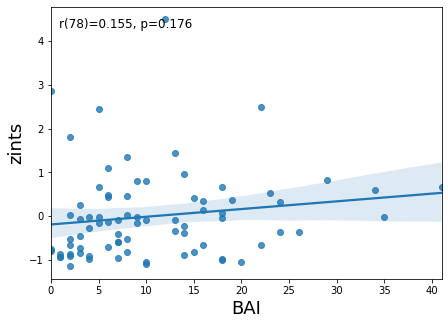

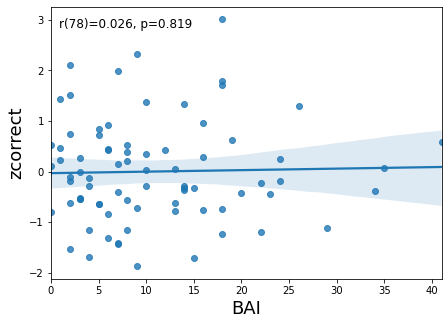

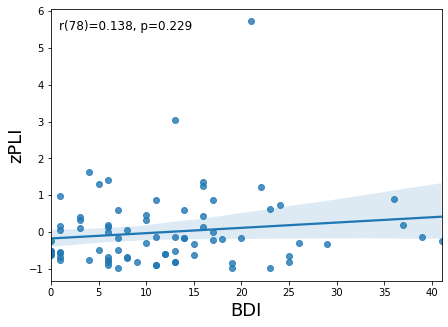

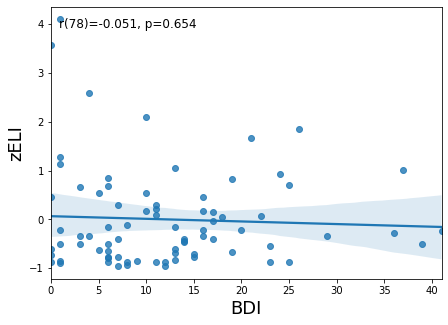

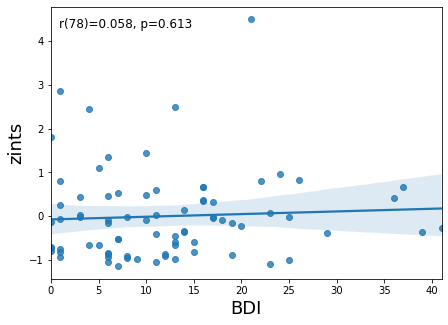

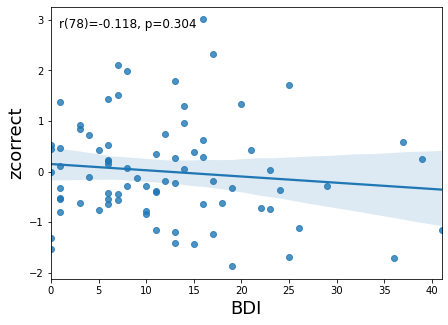

In [137]:
xs = ['BAI', 'BDI']
ys = ['zPLI', 'zELI', 'zints', 'zcorrect']
exp = 'catFR1' 

#Generate graphs for normalized values vs BAI and BDI score
for xi in xs:
    for yi in ys:
        if exp == 'FR1':
            sel_df = full_df.query("experiment=='FR1'")
        elif exp == 'catFR1':
            sel_df = full_df.query("experiment=='catFR1'")
        elif exp == 'both':
            sel_df = full_df_comb
        
        sel_df = sel_df.dropna(subset=[xi])
        x = sel_df[xi]
        y = sel_df[yi]
        n = len(sel_df)

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        grad, inter, r, p, std_err = stats.linregress(x, y)

        plt.figure(figsize=(7, 5))
        # plt.scatter(x, y)
        # plt.plot(x, poly1d_fn(x), '--k')
        # max_x = round(x.max(axis = 0) + 5, 5)
        # max_y = round(y.max(axis = 0) + 5, 5)
        # plt.xticks(np.arange(0, max_x, 5))
        # plt.yticks(np.arange(0, max_y, 10))
        plt.xlabel(xi,fontsize=18)
        plt.ylabel(yi,fontsize=18)
#         print('r = ',r, 'p = ', p)
#         print('y =', grad, '*x + ', inter)
#         plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
        plt.text(x.min()+float(np.ptp(x)/50), y.max()-float(np.ptp(y)/30), 'r(%.0f)=%.3f, p=%.3f '%(len(x),r,p),fontsize=12)
        g = sb.regplot(data = df_filter, x=x, y=y)
#         plt.title(xi + ' vs ' + yi)
        #plt.savefig(xi +' vs '+ yi + ': ' + exp +'.pdf')
        # ax.set_xlim(0, 25)
        # ax.set_xticks(range(0,25), 5)


In [98]:
full_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrect
0,8.0,2.0,0.890316,0.937747,2.778656,1.828063,FR1,R1001P,0.657593,0.998357,0.913241,-0.442907
1,9.0,0.0,0.100000,0.220000,4.740000,0.320000,FR1,R1002P,-0.890955,-0.658435,-0.879760,1.320577
2,7.0,7.0,0.449231,0.535385,4.120000,0.984615,FR1,R1006P,-0.206671,0.069575,-0.089570,0.763123
3,2.0,1.0,0.130435,0.391304,2.456522,0.521739,FR1,R1010J,-0.831321,-0.263009,-0.639903,-0.732545
4,0.0,2.0,0.083333,0.625000,2.833333,0.708333,FR1,R1018P,-0.923612,0.276436,-0.418054,-0.393746
...,...,...,...,...,...,...,...,...,...,...,...,...
160,5.0,6.0,0.200000,0.600000,3.200000,0.800000,catFR1,R1526J,-0.514695,0.190308,-0.162231,-0.632525
161,18.0,16.0,0.277778,1.194444,9.638889,1.472222,catFR1,R1530J,-0.339756,1.356937,0.664803,3.010232
162,12.0,21.0,1.166667,3.416667,5.083333,4.583333,catFR1,R1533J,1.659548,5.718164,4.492395,0.432958
163,24.0,17.0,0.253788,0.950758,4.001894,1.204545,catFR1,R1536J,-0.393714,0.878688,0.335481,-0.178859


Ttest_indResult(statistic=2.270185225419638, pvalue=0.027136128028955406) BAI FR1 average PLIs
Ttest_indResult(statistic=1.0372275216805888, pvalue=0.30416861966785513) BAI FR1 average ELIs
Ttest_indResult(statistic=1.836703847017928, pvalue=0.07165970980590232) BAI FR1 average ints
Ttest_indResult(statistic=-0.20392238401556761, pvalue=0.8391668266824641) BAI FR1 average correct recalls
Ttest_indResult(statistic=1.6706993506884216, pvalue=0.10172295207269066) BDI FR1 average PLIs
Ttest_indResult(statistic=1.2995432523893666, pvalue=0.20037583668327702) BDI FR1 average ELIs
Ttest_indResult(statistic=1.567066664157566, pvalue=0.1241050067095881) BDI FR1 average ints
Ttest_indResult(statistic=-0.24785047442777608, pvalue=0.805377590874161) BDI FR1 average correct recalls
Ttest_indResult(statistic=3.0403943689187947, pvalue=0.003891456162996429) BAI catFR1 average PLIs
Ttest_indResult(statistic=-0.007265403636937205, pvalue=0.9942345156934695) BAI catFR1 average ELIs
Ttest_indResult(stati

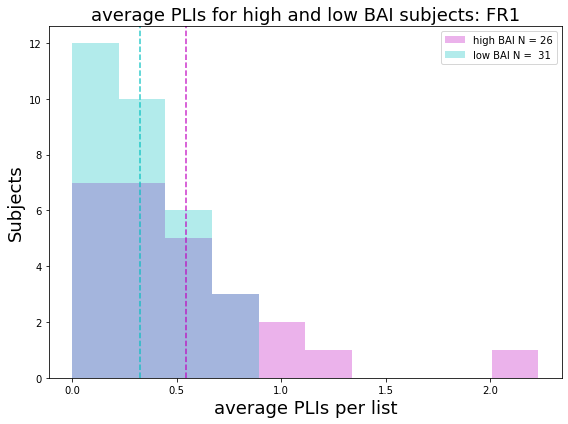

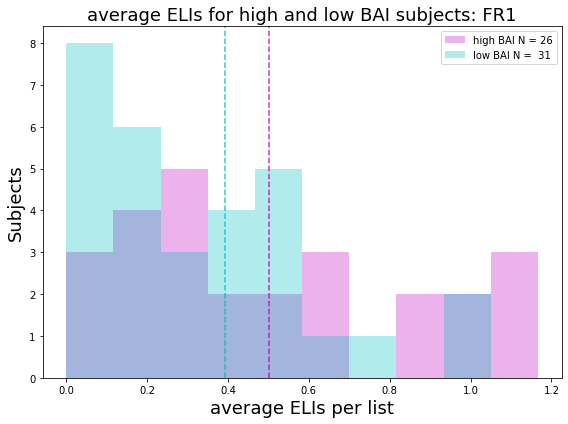

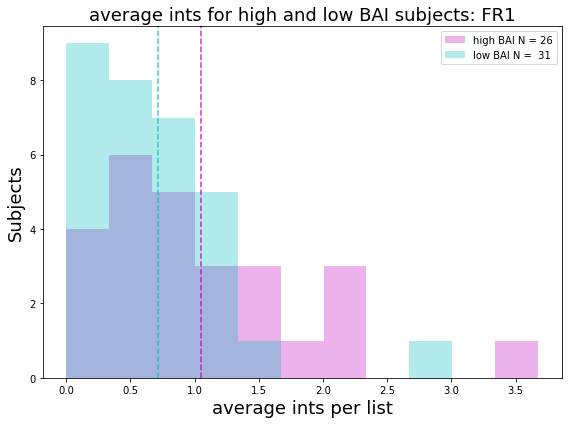

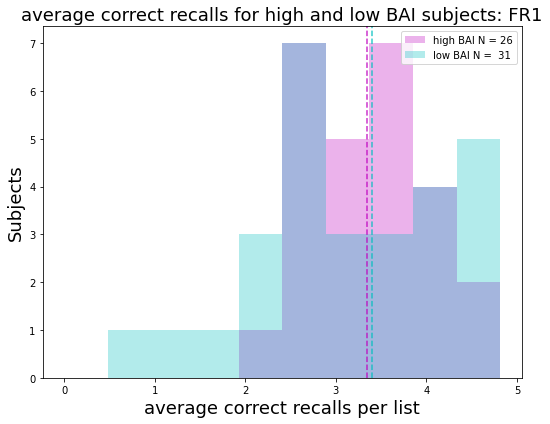

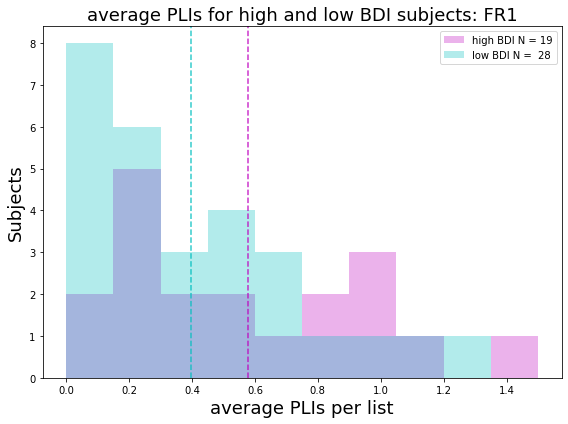

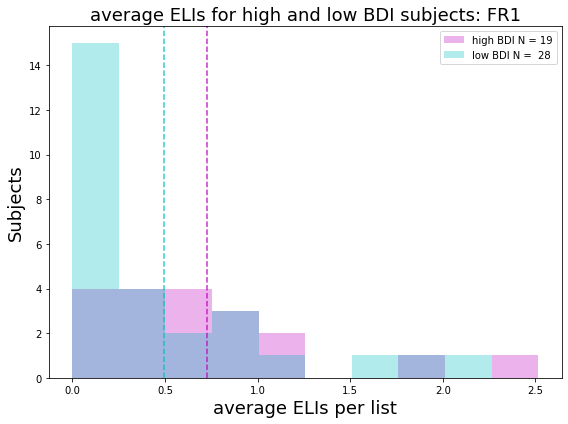

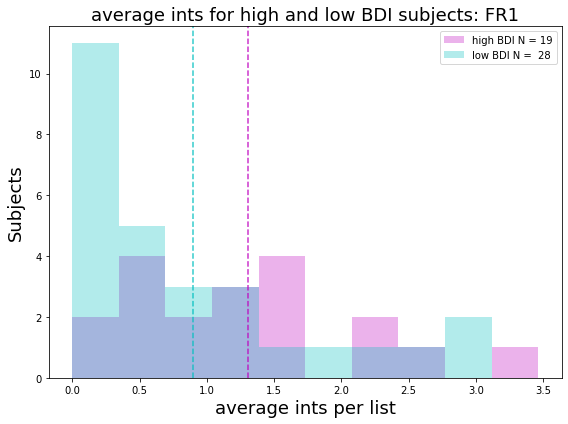

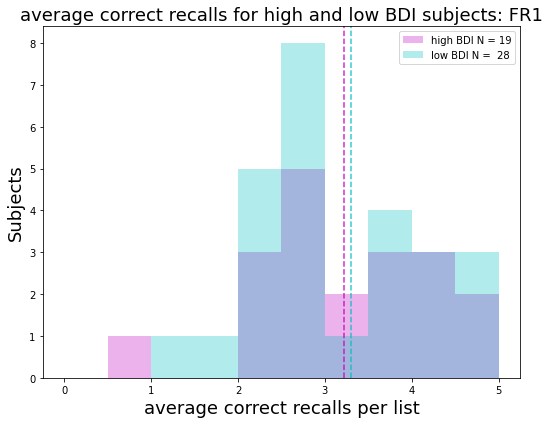

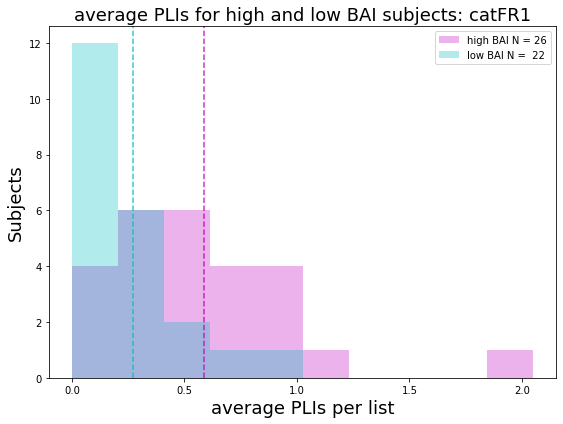

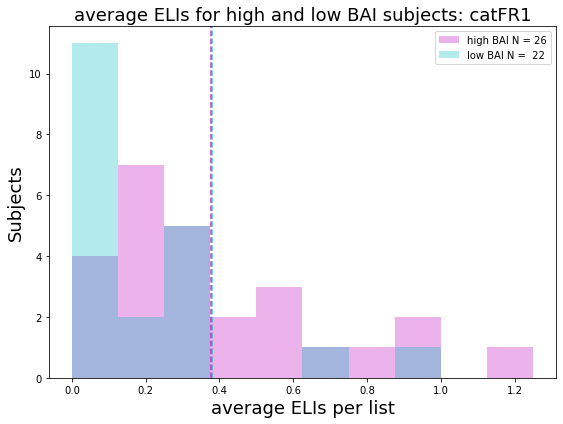

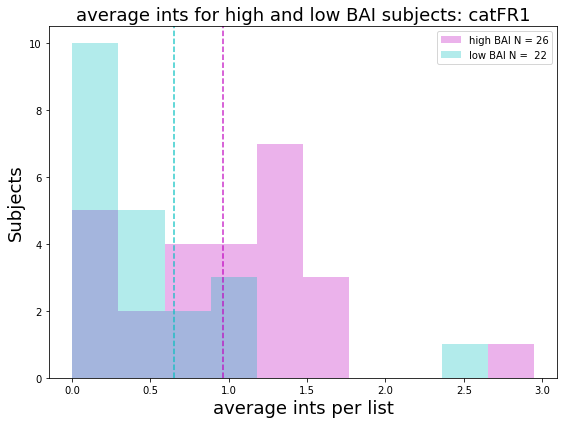

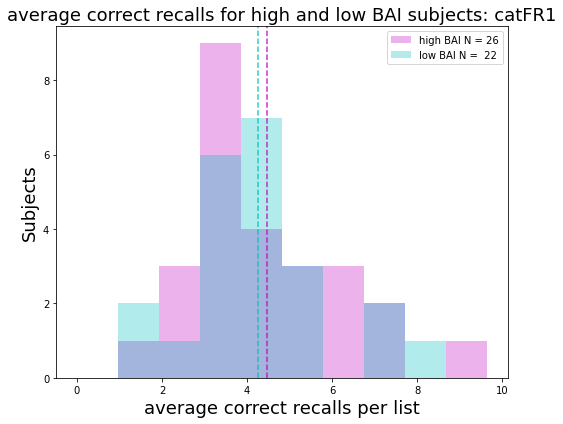

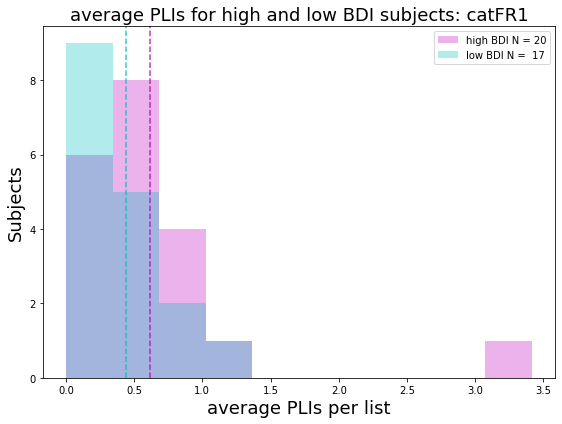

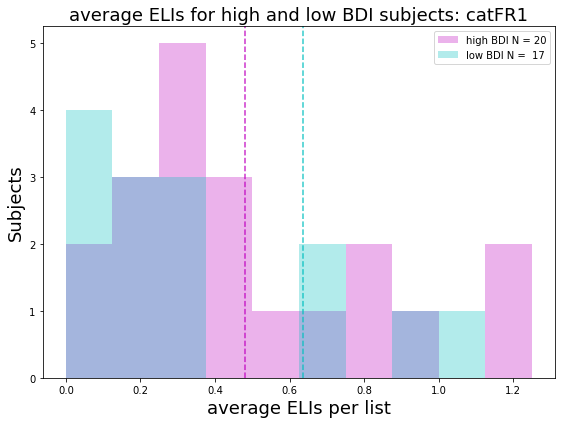

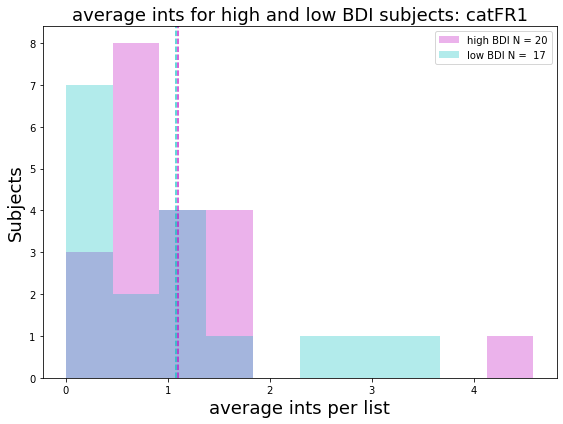

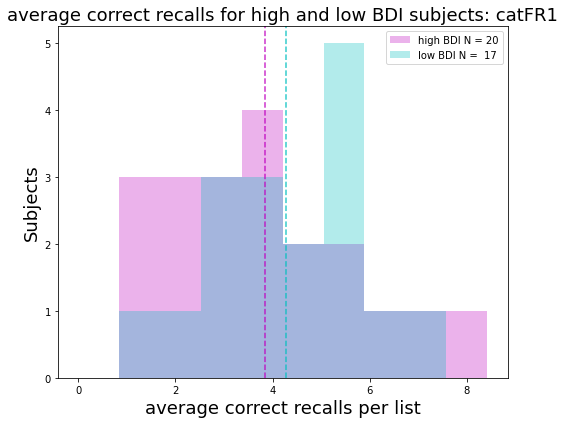

In [151]:
dependents = ['average PLIs', 'average ELIs', 'average ints', 'average correct recalls']
metrics = ['BAI','BDI']
levels = ['high','low']

#Compare high and low BAI/BDI subjects for PLIs, ELIs, and correct recalls in both experiments, already averaged by lists and subject in full_df
for exp in experiments:
    for met in metrics:
        for dep in dependents:
            split_sum_df = pd.DataFrame([])
            
            exp_df = full_df[full_df['experiment']==exp]
            exp_df_highA = exp_df[exp_df['BAI']>BAI_high]
            exp_df_lowA = exp_df[exp_df['BAI']<BAI_low]
            exp_df_highD = exp_df[exp_df['BDI']>BDI_high]
            exp_df_lowD = exp_df[exp_df['BDI']<BDI_low]
            if met=='BAI':
                exp_df_high = exp_df_highA
                exp_df_low = exp_df_lowA
            elif met=='BDI':
                exp_df_high = exp_df_highD
                exp_df_low = exp_df_lowD
            high_dep = exp_df_high[dep]
            low_dep = exp_df_low[dep]
            highN = str(len(high_dep))
            lowN = str(len(low_dep))

            plt.figure(figsize=(8,6), tight_layout=True)
            step = max(high_dep)/10
            bins = np.arange(0, max(high_dep)+step, step)
            plt.hist(high_dep, bins=bins, alpha=0.3, label='high '+met+' N = '+highN, color='m')
            plt.hist(low_dep, bins=bins, alpha=0.3, label='low '+met+' N =  '+lowN, color='c')

###If we want to plot percentage of subjects in each group for the histogram (high BAI/BDI groups are smaller than low):

#             plt.hist(high_dep, weights=np.ones(len(high_dep)) / len(high_dep), bins=10, alpha=0.5, label='high '+met, color='m')
#             plt.hist(low_dep, weights=np.ones(len(low_dep)) / len(low_dep), bins=10, alpha=0.5, label='low '+met, color='c')
#             plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
            
            plt.legend(loc='upper right')

            plt.xlabel(dep+' per list',fontsize=18)
            plt.ylabel('Subjects',fontsize=18)
            plt.title(dep+' for high and low '+met+' subjects: '+exp,fontsize=18)
    #         plt.savefig('Histogram of high/low performance.pdf')

            high_mean = np.mean(high_dep)
            high_median = np.median(high_dep)
            low_mean = np.mean(low_dep)
            low_median = np.median(low_dep)
            t = stats.ttest_ind(high_dep, low_dep)
            print(t,met,exp,dep)

            plt.axvline(x=high_mean, color='m', linestyle='--',alpha=0.8)
#             plt.text(high_mean,15,'  Mean: %.1f' %(high_mean/30))
    #         plt.axvline(x=high_median, color='k', linestyle='--',alpha=0.5)
            plt.axvline(x=low_mean, color='c', linestyle='--',alpha=0.8)
#             plt.text(high_median,15,'  Mean: %.1f' %(high_median/30))
    #         plt.axvline(x=low_median, color='k', linestyle='--',alpha=0.5)
#             print('mean diff =', high_mean-low_mean)
#             print('median diff =', high_median-low_median)